### SMS Spam Classification (NLP) and a prediction model that will accurately classify which texts are spam

 

Tools & Method - Spam Classification using the .csv as data corpus with classification, data cleaning and NLP leveraging Python (with numpy,pandas,sklearn and nltk)

Data - The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. The file contains one message per line. It contains one set of SMS messages in English of 5,574 messages, tagged according to either being ham (legitimate) or spam.

**[Problem Statement about the data]**: The identification of the text of spam messages in the claims is a very hard and time-consuming task, and it involved carefully scanning hundreds of web pages

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


nltk.download('stopwords')
nltk.download('wordnet')

In [5]:
df=pd.read_csv(r'C:\Users\JG617TE\Downloads\spam.csv',encoding='ISO-8859-1')

df.shape

(5572, 5)

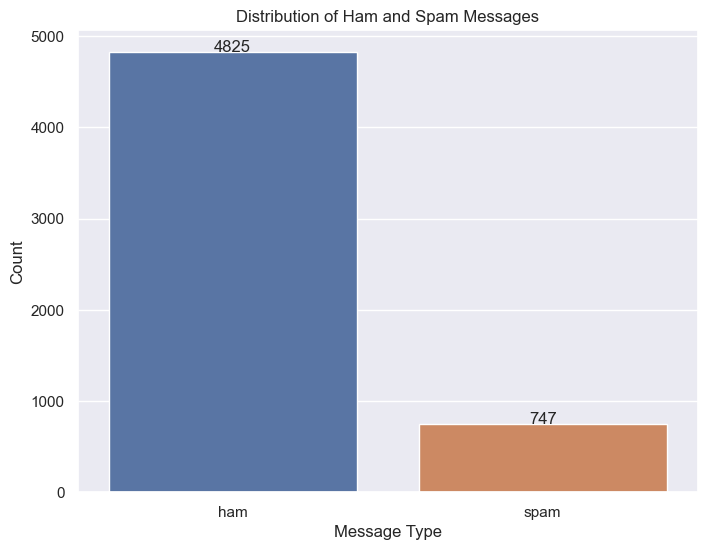

In [6]:

# Plot the distribution of 'ham' and 'spam' messages
sns.set(style="darkgrid")
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='v1', data=df)
plt.title('Distribution of Ham and Spam Messages')
plt.xlabel('Message Type')
plt.ylabel('Count')

# Annotate the bars with their respective counts
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')

plt.show()

As we can see in the above dataset, it is highly imblance and there are only 747 spam messages out of 5572 records 

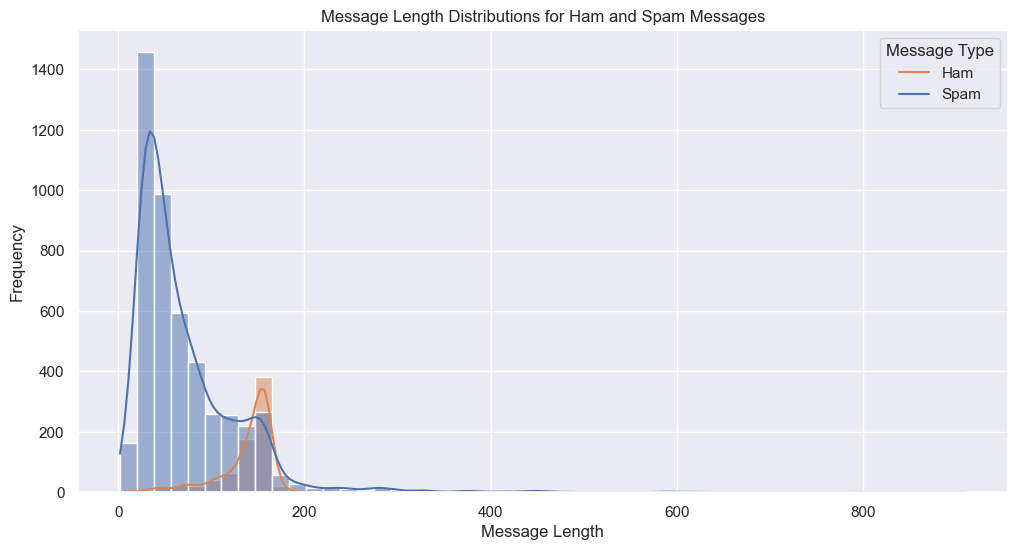

In [7]:
# Calculate the message length for each message
df['message_length'] = df['v2'].apply(len)

# Plot the message length distributions for ham and spam messages
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='message_length', hue='v1', bins=50, kde=True)
plt.title('Message Length Distributions for Ham and Spam Messages')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.legend(title='Message Type', labels=['Ham', 'Spam'])

plt.show()

The above distribution plot shows us the differences between 'ham' and 'spam' messages in terms of word usage and message length. 

In [8]:
def preprocess_text(text):
    
    lemmatizer = WordNetLemmatizer()
    # Remove non-alphabetic characters and convert to lowercase
    words = nltk.word_tokenize(text.lower())
    
    # Remove stopwords and lemmatize the words
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]
    
    return ' '.join(words)


df['processed_text'] = df['v2'].apply(preprocess_text)

Lets try to plot the wordColud of both types and to check what are the most words we are getting in spam 

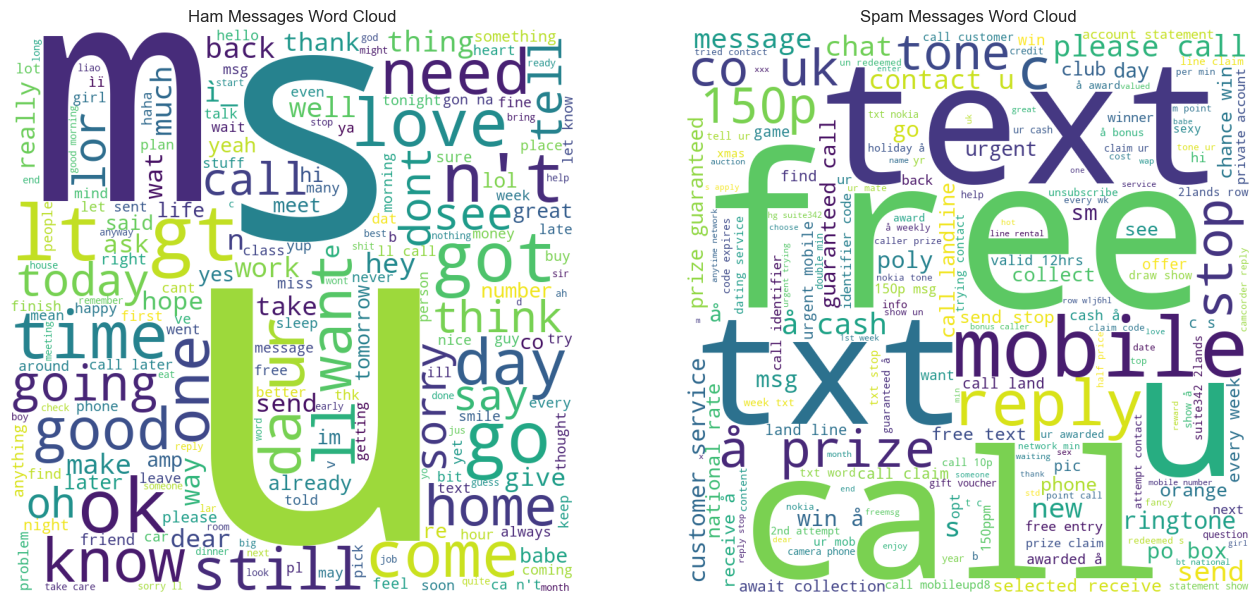

In [9]:
from wordcloud import WordCloud

# Generate separate texts for ham and spam messages
ham_text = ' '.join(df[df['v1'] == 'ham']['processed_text'])
spam_text = ' '.join(df[df['v1'] == 'spam']['processed_text'])

# Create word clouds for ham and spam messages
ham_wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(ham_text)
spam_wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(spam_text)

# Plot the word clouds
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.imshow(ham_wordcloud)
ax1.axis('off')
ax1.set_title('Ham Messages Word Cloud')

ax2.imshow(spam_wordcloud)
ax2.axis('off')
ax2.set_title('Spam Messages Word Cloud')

plt.show()

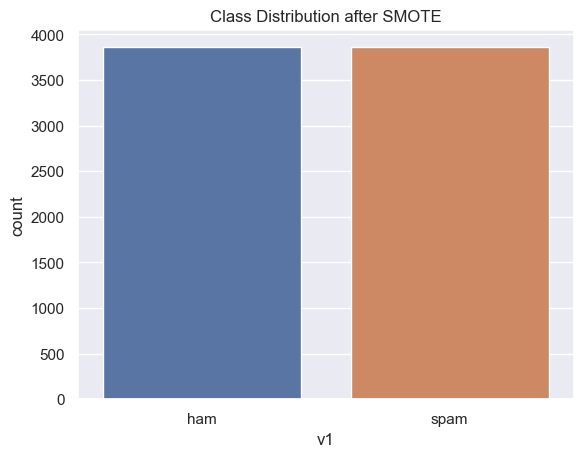

In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['processed_text'], df['v1'], test_size=0.2, random_state=42)

# Vectorize the text data
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_counts, y_train)

# Visualize the class distribution
sns.countplot(y_train_smote)
plt.title('Class Distribution after SMOTE')
plt.show()

In [11]:
# Define the pipeline with SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
pipeline = ImbPipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('smote', SMOTE(random_state=42)),
    ('clf', None),  # Placeholder for the classifier
])

# Define the classifiers and their parameters
classifiers_params = [
    {
        'clf': [MultinomialNB()],
        'clf__alpha': [0.1, 0.5, 1],
    },
    {
        'clf': [LogisticRegression()],
        'clf__C': [0.1, 1, 10],
        'clf__solver': ['newton-cg', 'lbfgs', 'liblinear'],
    },
    {
        'clf': [SVC()],
        'clf__C': [0.1, 1, 10],
        'clf__kernel': ['linear', 'rbf'],
    },
]

In [12]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, classifiers_params, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('smote', SMOTE(random_state=42)),
                                       ('clf', None)]),
             param_grid=[{'clf': [MultinomialNB()],
                          'clf__alpha': [0.1, 0.5, 1]},
                         {'clf': [LogisticRegression()], 'clf__C': [0.1, 1, 10],
                          'clf__solver': ['newton-cg', 'lbfgs', 'liblinear']},
                         {'clf': [SVC(C=10, kernel='linear')],
                          'clf__C': [0.1, 1, 10],
                          'clf__kernel': ['linear', 'rbf']}],
             scoring='accuracy')

In [13]:
# Get the best classifier
best_clf = grid_search.best_estimator_

# Make predictions on the testing set
y_pred = best_clf.predict(X_test)

In [14]:
# Evaluate the best model's performance
print("Best Classifier:", best_clf.named_steps['clf'])
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Best Classifier: SVC(C=10, kernel='linear')
Accuracy: 0.9820627802690582
Confusion Matrix:
 [[960   5]
 [ 15 135]]
Classification Report:
               precision    recall  f1-score   support

         ham       0.98      0.99      0.99       965
        spam       0.96      0.90      0.93       150

    accuracy                           0.98      1115
   macro avg       0.97      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115



While dealing with imbalanced datasets, using only accuracy as a performance metric can be misleading. In such cases, it's better to use additional metrics like precision, recall, F1-score, and the confusion matrix to evaluate the model's performance.